# Welcome to this notebook on Simultaneous Perturbation Stochastic Approximation (SPSA) in N dimensions.

## What is SPSA?

SPSA is an algorithm developed by Spall (see: https://www.jhuapl.edu/spsa/). It can be used if noisy and unbiased measurements of the gradient $g(\boldsymbol{\theta}$) are available. It can also be used if only (noisy) measurements of the loss function $f(\boldsymbol{\theta})$ are available.

The advantage of SPSA compared to other algorithms is that only two loss measurements are required to generate an update. Therefore, SPSA is scalable.


## How does SPSA work?
Let $\eta_i \in (0, \infty)$ be a perturbation vector and $\Delta_i$ be a random vector such that $\{\Delta_i\}$ is an iid sequence with $\Delta_i(k)$ and $1/\Delta_i(k)$ bounded and symmetric around zero. The components $\Delta_i(k)$ are mutually independent. In practice, often the following binary random variable is used for $\Delta_i$:

$$
\mathbb{P}(\Delta_i(j) = -1) = \frac{1}{2} = \mathbb{P}(\Delta_i(j) = 1),
$$
for all $i$ and $j$.


The SPSA algorithm is then as follows:

___
**Start**: Choose starting value $\theta_0$, learning rate $\epsilon$ and take $i = 0$.
___
**Algorithm**:
1) Calculate ($g_i^{SPSA}(\theta_i))(j) = \frac{f(\theta_i+\eta_i\Delta_i)-f(\theta_i-\eta_i\Delta_i)}{2\eta_i\Delta_i(j)}$. 
2) Update $\theta_{i+1} = \theta_{i} - \epsilon (g_i^{SPSA}(\theta_i))$.
3) (a) stop if $i$ large or $|\theta_{i+1}-\theta_{i}|$ small enough.  
   (b) else: update $i$ to $i+1$ and go back to (1).
___

In the implementation below, you can perform SPSA on a two-dimensional function.

You can also experiment with what happens if stochastic noise is added to the objective function. This is interesting, as in (most) practical situations only noisy measurements of the objective function are available. You can also estimate the gradient multiple times and use the average gradient as the update.

You can also experiment with the difference between a fixed learning rate $\epsilon$ and a decreasing learning rate according to $\epsilon = \frac{1}{i+1}$.

## Try SPSA yourself and see what happens

In [1]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Fill in the objective function you would like to use:
def objective_f(theta, STOCHASTIC, MU, SIGMA, rng_noise):
    #theta should be a list or array containing all values for all theta variables. 
    #By using theta[0], theta[1], ... theta[N], you can access the variables \theta_0,...., \theta_N and use these in the function.
    
    function = np.power(theta[0], 2) + np.power(theta[1], 2)#You can change this function.
    if STOCHASTIC:
        noise =  add_noise(MU, SIGMA, rng_noise)
        function = function + noise
    
    return function

In [3]:
# Adds normally distributed noise to the objective function. 
def add_noise(MU, SIGMA, rng_noise):
    return rng_noise.normal(MU, SIGMA)

In [4]:
# Fill in the number of iterations you would like to run SPSA.
NR_ITERATIONS = 150

In [5]:
# Do you want to use decreasing or fixed epsilon?
EPSILON_TYPE = 'fixed' #'fixed' or 'decreasing'
# Fill in the value for epsilon. The decreasing epsilon uses the form EPSILON_VALUE/(i+1).
EPSILON_VALUE = 0.01

In [6]:
# Fill in the starting values for the optimisation:
THETA_0 = [8, 10] #As a list e.g., [10, 5]. Note that the number of initial values should equal the number of variables.

In [7]:
# Do you want to do maximization or minimization?
OPTIMIZATION_TYPE = 'minimization' # 'minimization' or 'maximization' 

In [8]:
# Which seed do you want to use?
SEED = 10

In [9]:
# Do you want to add stochasticity?
STOCHASTIC = False #False or True
MU = 0 # mu parameter of the normal distribution for the noise.
SIGMA = 1 # sigma parameter of the normal distribution for the noise.
NOISE_SEED = 0 # Seed for the added noise. SEED and NOISE_SEED should NOT have the same value.

# In case of stochasticity, do you want to estimate the gradient multiple times and use the average as update?
BATCH = False #False or True
NR_ESTIMATES = 10

In [10]:
def estimate_gradient(theta, i, STOCHASTIC, MU, SIGMA, BATCH, NR_ESTIMATES, rng, rng_noise):
    delta_i = rng.choice((-1, 1), size = len(theta))
    eta_i = 1/(i+1)
    
    if BATCH:
        gradient_estimates = np.zeros((NR_ESTIMATES, len(theta)))
        for n in range(NR_ESTIMATES):                 
            perturbation_high = theta + eta_i*delta_i
            perturbation_low = theta - eta_i*delta_i
            obj_perturbation_high = objective_f(perturbation_high, STOCHASTIC, MU, SIGMA, rng_noise)
            obj_perturbation_low = objective_f(perturbation_low, STOCHASTIC, MU, SIGMA, rng_noise)
            numerator = obj_perturbation_high-obj_perturbation_low
            denominator = 2*eta_i*delta_i
            gradient_estimates[n] = np.divide(numerator, denominator)
        gradient_estimate = np.mean(gradient_estimates, axis=0)
    else:
        perturbation_high = theta + eta_i*delta_i
        perturbation_low = theta - eta_i*delta_i
        obj_perturbation_high = objective_f(perturbation_high, STOCHASTIC, MU, SIGMA, rng_noise)
        obj_perturbation_low = objective_f(perturbation_low, STOCHASTIC, MU, SIGMA, rng_noise)
        numerator = obj_perturbation_high-obj_perturbation_low
        denominator = 2*eta_i*delta_i
        gradient_estimate = np.divide(numerator, denominator)
                                  
    return gradient_estimate

In [11]:
# The SPSA algorithm
def SPSA(SEED, NOISE_SEED, THETA_0, EPSILON_TYPE, EPSILON_VALUE, NR_ITERATIONS, STOCHASTIC, MU, SIGMA, BATCH, NR_ESTIMATES):
    rng = np.random.default_rng(SEED)
    rng_noise = np.random.default_rng(NOISE_SEED)
    thetas = np.zeros((NR_ITERATIONS+1, len(THETA_0)))
    gradients = np.zeros((NR_ITERATIONS, len(THETA_0)))
    objective_values = np.zeros(NR_ITERATIONS+1)
    thetas[0] = THETA_0
    objective_values[0] = objective_f(thetas[0], STOCHASTIC, MU, SIGMA, rng_noise)

    for i in range(NR_ITERATIONS):
        g = estimate_gradient(thetas[i], i, STOCHASTIC, MU, SIGMA, BATCH, NR_ESTIMATES, rng, rng_noise)
        gradients[i] = g
        if EPSILON_TYPE == 'fixed':
            if OPTIMIZATION_TYPE == 'minimization':
                thetas[i+1] = thetas[i] - EPSILON_VALUE * g
            if OPTIMIZATION_TYPE == 'maximization':
                thetas[i+1] = thetas[i] + EPSILON_VALUE * g
        if EPSILON_TYPE == 'decreasing':
            if OPTIMIZATION_TYPE == 'minimization':
                thetas[i+1] = thetas[i] - EPSILON_VALUE/(i+1) * g
            if OPTIMIZATION_TYPE == 'maximization':
                thetas[i+1] = thetas[i] + EPSILON_VALUE/(i+1) * g
        objective_values[i+1] = objective_f(thetas[i+1], STOCHASTIC, MU, SIGMA, rng_noise)
        
    return thetas, gradients, objective_values, rng_noise

In [12]:
# Plot the iterates and objective values during the optimisation
def plot_iterate_objective_gradient(thetas, gradients, objective_values, STOCHASTIC, MU, SIGMA, rng_noise):
    
    if thetas.shape[1] == 2:
        #2-dimensional plots.
        fig, axs = plt.subplots(2,2, figsize=(10,10))

        # Plot the iterate
        axs[0,0].plot(thetas.T[0], color="darkblue", label = r'$\theta_0$')
        axs[0,0].plot(thetas.T[1], color="deepskyblue", label = r'$\theta_1$')
        axs[0,0].set_xlabel("Iteration")
        axs[0,0].set_ylabel(r"$\theta_n$")
        axs[0,0].set_title(r"$\theta_n$")
        axs[0,0].legend()

        # plot contour
        r = 12
        x = np.linspace(-r, r, 100)
        y = np.linspace(-r, r, 100)

        X, Y = np.meshgrid(x, y)
        Z = np.array([[ objective_f( [X[i,j], Y[i,j]], False, 0, 1, rng_noise) for j in range(len(x))] for i in range(len(x))])

        CS = axs[0,1].contour(X, Y, Z)
        axs[0,1].clabel(CS, inline=1, fontsize=10)

        axs[0,1].plot(thetas.T[0], thetas.T[1], c="red", linewidth=1)
        axs[0,1].set_xlim(-r,r)
        axs[0,1].set_ylim(-r,r)
        axs[0,1].set_xlabel(r"$\theta_0$")
        axs[0,1].set_ylabel(r"$\theta_1$") 

        # Plot the objective values
        axs[1,0].plot(objective_values, color="darkblue")
        axs[1,0].set_xlabel("Iteration")
        axs[1,0].set_ylabel(r"f($\theta_n$)")
        axs[1,0].set_title(r"f($\theta_n$)")

        # Plot the estimated gradients
        axs[1,1].plot(gradients.T[0], color="darkblue", label = r'$g^{SPSA}_0$')
        axs[1,1].plot(gradients.T[1], color="deepskyblue", label = r'$g^{SPSA}_1$')
        axs[1,1].set_xlabel("Iteration")
        axs[1,1].set_ylabel(r"$g^{SPSA}$($\theta_n$)")
        axs[1,1].set_title(r"$g^{SPSA}$($\theta_n$)")
        axs[1,1].legend()
        
    else:
        #N-dimensional plots.
        fig, axs = plt.subplots(1,3, figsize=(15,5))

        # Plot the iterate
        for i in range(thetas.shape[1]):
            axs[0].plot(thetas.T[i], label = rf'$\theta_{i}$')
        axs[0].set_xlabel("Iteration")
        axs[0].set_ylabel(r"$\theta_n$")
        axs[0].set_title(r"$\theta_n$")
        axs[0].legend()

        # Plot the objective values
        axs[1].plot(objective_values, color="darkblue")
        axs[1].set_xlabel("Iteration")
        axs[1].set_ylabel(r"f($\theta_n$)")
        axs[1].set_title(r"f($\theta_n$)")

        # Plot the estimated gradients
        for i in range(thetas.shape[1]):
            axs[2].plot(gradients.T[i], label = rf'$g^{{SPSA}}_{i}$')
        axs[2].set_xlabel("Iteration")
        axs[2].set_ylabel(r"$g^{SPSA}$($\theta_n$)")
        axs[2].set_title(r"$g^{SPSA}$($\theta_n$)")
        axs[2].legend()

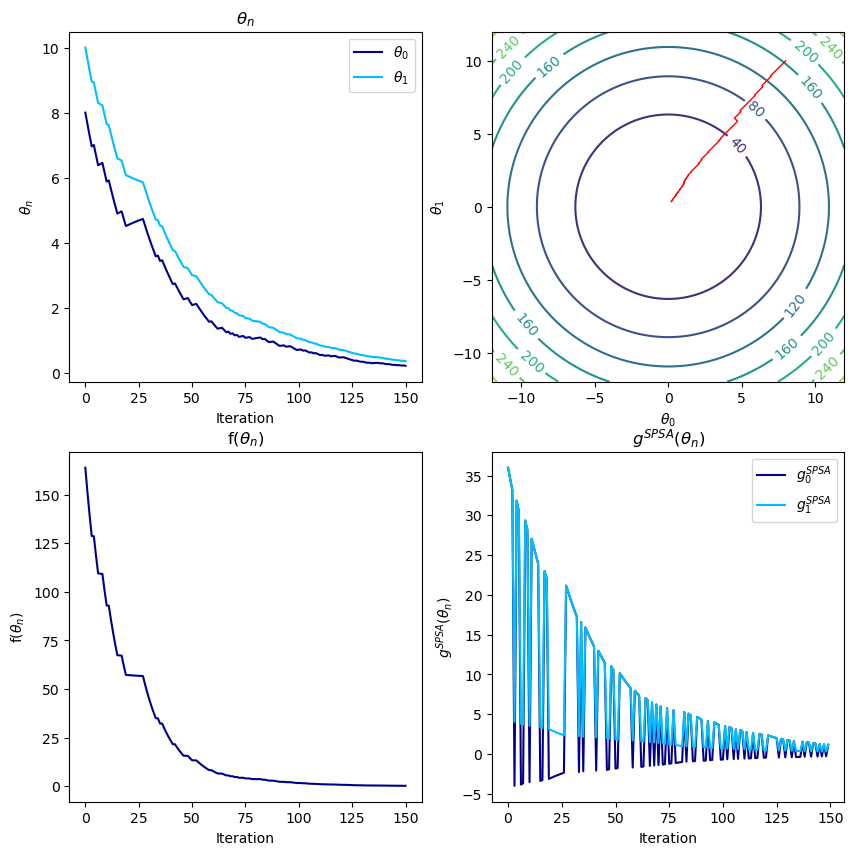

In [13]:
# Run SPSA and plot the optimisation
thetas, gradients, objective_values, rng_noise = SPSA(SEED, NOISE_SEED, THETA_0, EPSILON_TYPE, EPSILON_VALUE, NR_ITERATIONS, STOCHASTIC, MU, SIGMA, BATCH, NR_ESTIMATES)
plot_iterate_objective_gradient(thetas, gradients, objective_values, STOCHASTIC, MU, SIGMA, rng_noise)